# Download Data

In [7]:
!wget -nc 140.114.76.113:8000/ccpd6000.zip
!unzip -nq ccpd6000.zip
!ls -alh

--2019-12-11 15:50:32--  http://140.114.76.113:8000/ccpd6000.zip
Connecting to 140.114.76.113:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332013713 (317M) [application/zip]
Saving to: ‘ccpd6000.zip’

ccpd6000.zip        100%[===================>] 316.63M  10.6MB/s    in 31s     

2019-12-11 15:51:02 (10.3 MB/s) - ‘ccpd6000.zip’ saved [332013713/332013713]

total 317M
drwxr-xr-x 1 root root 4.0K Dec 11 15:51 .
drwxr-xr-x 1 root root 4.0K Dec 11 15:49 ..
drwxr-xr-x 4 root root 4.0K Nov 19 11:35 ccpd6000
-rw-r--r-- 1 root root 317M Nov 19 11:44 ccpd6000.zip
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 .config
drwxr-xr-x 1 root root 4.0K Dec  6 16:53 sample_data


In [8]:
!sha256sum ccpd6000.zip

977d7124a53e565c3f2b371a871ee04ebbe572f07deb0b38c5548ddaae0cb2c9  ccpd6000.zip


# Init and Utility

In [0]:
import random
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
import glob
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import functional as tf
from torch.utils.data import DataLoader, Dataset, Subset, ConcatDataset
import cv2
from PIL import Image
from tqdm import tqdm
# Fix the seed for reproducibility
seed = 999
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Some constants
FIELDS = ['BR_x', 'BR_y', 'BL_x', 'BL_y', 'TL_x', 'TL_y', 'TR_x', 'TR_y'] # the fields in csv
IMG_SIZE = (192, 320) # the input image size (width, height) of the model
ROOT_DIR = './ccpd6000/' # the root directory of the dataset

### Function

In [0]:
def draw_kpts(img, kpts, c='red', r=2.0):
    '''
    Draw `kpts` on `img`. `img` is modified inplace.
    Args:
        img: (PIL.Image) the image to be drawn
        kpts: (torch.tensor) the normalized positions (x, y) of keypoints, shaped [4, 2]
        c: (str) color
        r: (float) radius of the drawn circle
    Return:
        img: (PIL.Image) the result.
    '''
    draw = ImageDraw.Draw(img)
    size = torch.tensor([img.size]).float()
    kpts = kpts.view(4, 2) * size
    kpts = kpts.numpy().tolist()
    for x, y in kpts:
        draw.ellipse([x - r, y - r, x + r, y + r], fill=c)
    return img

# Part 1 : 
##### Training the model and select the model with best performance

### Training Data

In [0]:
class TrainData(Dataset):
    def __init__(self, csv_path, img_dir):
        super().__init__()
        self.anns = pd.read_csv(csv_path).to_dict('records') # List of Dict
        self.img_dir = img_dir+'/'

    def __len__(self):
        '''Return the number of sample
        '''
        return len(self.anns)

    def __getitem__(self, idx):
        '''Map index `idx` to a sample, i.e., an image and its keypoints

        Args:
            idx: (int) index
        Return:
            img: (torch.FloatTensor) values in 0 ~ 1 and shaped [3, H, W]
            kpt: (torch.FloatTensor) normalized positions of 
                bottom-right, bottom-left, top-left, top-right corners. 
                For example, position (256, 256) of an (512, 512) image should be (0.5, 0.5)
                `kpt` should have same order as `FIELDS` and is shaped [8].
        '''
        def changeDim(old):
            '[H,W,3] -> [3,H,W]'
            a,b,c = old[:,:,0],old[:,:,1],old[:,:,2]
            return  np.array([a,b,c])
            
        imgPath = self.img_dir+self.anns[idx]['name']
        img = cv2.imread(imgPath,cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img/255.0,dsize=(IMG_SIZE[0],IMG_SIZE[1]))
        H,W = img.shape[0],img.shape[1]
#        norm_img = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_img = changeDim(img1)
        Dict = self.anns[idx]
        kpt = [Dict['BR_x']/W,Dict['BR_y']/H,Dict['BL_x']/W,Dict['BL_y']/H,\
               Dict['TL_x']/W,Dict['TL_y']/H,Dict['TR_x']/W,Dict['TR_y']/H]
        norm_img= torch.FloatTensor(norm_img)
        kpt = torch.FloatTensor(kpt)
        return norm_img, kpt

3000
torch.Size([3, 320, 192])
tensor(1.)
torch.Size([8])


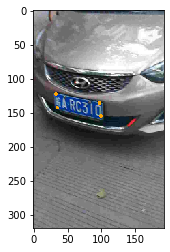

In [12]:
# do some checking and visualization
data = TrainData(ROOT_DIR + '/train.csv', ROOT_DIR + '/train_images')
print(len(data))    # should be 3000

img, kpt = data[0] # get a sample
print(img.size())   # should be [3, H, W]
print(img.max())    # should be <= 1.0
print(kpt.size())   # should be [8]

img = tf.to_pil_image(img) # convert tensor of shape (3, H, W) to PIL.Image
vis = draw_kpts(img, kpt, c='orange')
plt.imshow(vis)
plt.show()

### TRIANING MODEL

1. function that will used in model 
2. the moedel 

#### 1. Function

In [0]:
class ConvBlock(nn.Module):
    def __init__(self, cin, cout):
        super().__init__() # necessary
        self.conv = nn.Conv2d(cin, cout, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(cout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


#### 2. Model

In [0]:
class Net(nn.Module):
    def __init__(self):
        '''Defines parameters (what layers you gonna use)
        '''
        super().__init__() # necessary
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((4, 4)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            nn.MaxPool2d((2, 2)),
        )
        self.regression = nn.Sequential(
            Flatten(), nn.Linear(480, 32), nn.ReLU(), nn.Linear(32, 8), nn.Sigmoid()
        )

    def forward(self, img_b):
        '''Define how layers are interact, that is, the forward function.
        In this network, img_b is passed to self.features and 
        the result is passed to self.regression.

        Args:
            img_b: (torch.FloatTensor) input images (mini-batch), shaped [N, 3, H, W]
        Return:
            kpt_b: (torch.FloatTensor) the predictions (mini-batch), shaped [N, 8]
        '''
#        print(img_b.size())
        fea = self.features(img_b)
        pred = self.regression(fea)
        return pred

In [15]:
# Do some checking
loader = DataLoader(data, batch_size=10) # dataloader constructs mini-batch from a dataset
img_b, kpt_b = next(iter(loader)) # get an mini-batch
print(img_b.size()) # expects [N, 3, H, W]
print(kpt_b.size()) # expects [N, 8]

# Do a forwarding
#device = 'cuda'     # the computing device, 'cuda' or 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device) # instantiate network and move it to device
criterion = nn.MSELoss()  # the criterion (loss function)

img_b = img_b.to(device)
kpt_b = kpt_b.to(device)
pred_b = model(img_b)
loss = criterion(pred_b, kpt_b)
print(loss)

torch.Size([10, 3, 320, 192])
torch.Size([10, 8])
tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward>)


## Start to train!!

In [0]:
class Trainer:
    def __init__(self, log_dir,bz,lr1,MAXEPOCH,NUMWORKER):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir
        self.bz,self.lr1,self.NUMWORKER = bz,lr1,NUMWORKER

        # Datasets and dataloaders
        # 1. Split the whole training data into train and valid (validation)
        # 2. Construct visualization data (25 training samples, 25 validation samples)
        # 3. Make the corresponding dataloaders
        data = TrainData(ROOT_DIR + 'train.csv', ROOT_DIR + 'train_images')
        pivot = len(data) * 4 // 5
        self.train_set = Subset(data, range(0, pivot))
        self.valid_set = Subset(data, range(pivot, len(data)))
        self.visul_set = ConcatDataset(
            [
                Subset(self.train_set, random.sample(range(len(self.train_set)), k=25)),
                Subset(self.valid_set, random.sample(range(len(self.valid_set)), k=25)),
            ]
        )
        self.train_loader = DataLoader(self.train_set, bz, shuffle=True, num_workers=self.NUMWORKER)
        self.valid_loader = DataLoader(self.valid_set, bz, shuffle=False, num_workers=self.NUMWORKER)
        self.visul_loader = DataLoader(self.visul_set, bz, shuffle=False)

        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = Net().to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr1)
        self.max_epoch = MAXEPOCH
        self.minloss =10 
        self.bestCOM = ''
        self.bestDir = ''
    def run(self):
        metrics = {'train_loss': [], 'valid_loss': []}
        for self.epoch in range(self.max_epoch): # 5 epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            self.visul()              # visualization

            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            if valid_loss<self.minloss:
                self.minloss=valid_loss
                # Save the parameters(weights) of the model to disk
                modDir = self.log_dir/'{}-{}-{:.3f}.pkl'.format(self.bz,self.lr1,self.minloss)
                torch.save({'model_dict':self.model.state_dict(),
                            'optim_dict':self.optimizer.state_dict()
                            },modDir)
                self.bestCOM='bz{}-lr{}-{:.3f}'.format(self.bz,self.lr1,self.minloss)
                self.bestDir = modDir
        print('best:'+self.bestCOM)
                
        # Plot the loss curve against epoch
        plt.figure(figsize=(8,5))
        plt.plot(metrics['train_loss'], label='Training Loss')
        plt.plot(metrics['valid_loss'], label='Validation Loss')
        plt.title('Loss Plot',fontsize=15)
        plt.legend(loc=0)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_epo = []
        PRED=[]
        GND=[]
        for x_batch,y_batch in tqdm(self.train_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            self.optimizer.zero_grad()
            ps = self.model(x_batch)
            loss = criterion(ps, y_batch)
            loss.backward()
            self.optimizer.step()
            loss = loss.detach().cpu().numpy()
            loss_epo.append(loss)
            PRED.append(ps.detach().cpu().numpy())
            GND.append(y_batch.detach().cpu().numpy())
#            print('train loss:%.4f'%loss)
        loss_epo = np.array(loss_epo).mean()
#        print('rmse:',RMSE(PRED,GND))
        return loss_epo
    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_epo =[]
        for x_batch,y_batch in tqdm(self.valid_loader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            ps = self.model(x_batch)
            loss = criterion(ps, y_batch)
            loss = loss.detach().cpu().numpy()
            loss_epo.append(loss)
#            print('validation loss:%.4f'%loss)
        loss_epo = np.array(loss_epo).mean()
        return loss_epo
    @torch.no_grad()
    def visul(self):
        ''' Visualize some samples
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do:
            a. forward to get predictions
            b. visualize and save visualization to log_dir / f'{epoch:03d}'
        As a result, first 25 samples are from training data and last 25 samples are from validation.
        '''
        self.model.eval()
        epoch_dir = self.log_dir / f'{self.epoch:03d}'
        epoch_dir.mkdir(parents=True)
        idx = 0
        for img_b, kpt_b in iter(self.visul_loader):
            pred_b = self.model(img_b.to(self.device)).to('cpu')
            for img, kpt, pred in zip(img_b, kpt_b, pred_b):
                img = tf.to_pil_image(img)
                vis = draw_kpts(img, kpt, c='orange')
                vis = draw_kpts(img, pred, c='red')
                plt.imshow(vis)
                plt.show()
                vis.save(epoch_dir / f'{idx:03d}.jpg')
                idx += 1
                

In [0]:
def RMSE(PRED,GND):
    return np.sqrt(((np.array(PRED)-np.array(GND))**2).mean())

#### HYPERPARAMETER SETTING 

Setting the hyperparameter to do some grid serch.

After finish the searching,
it will print out which combination of the hyperparameters will lead to least validation loss.

In [0]:
log_dir = Path('./runs/') / f'{datetime.now():%b.%d-%H_%M_%S}'
log_dir.mkdir(parents=True)
MAXEPOCH = 40
BZ= [32]
LR = [ 1e-3]
NUMWORKER=8
minloss=0
for bz in BZ:
    for lr1 in LR: 
        log_dir = Path('./runs/') / f'{datetime.now():%b.%d-%H_%M_%S}'/'{}-{}'.format(bz,lr1)
        log_dir.mkdir(parents=True)
        train=Trainer(log_dir,bz,lr1,MAXEPOCH,NUMWORKER)
        train.run()
        #if train.minloss < minloss:
          #minloss = train.minloss
        bestCOM = train.bestCOM
        bestDir = train.bestDir
print('best:',bestCOM)

  0%|          | 0/19 [00:00<?, ?it/s]

# Part 2 :

## Testing

Use the unlabled data to test the model I selecetd, and will upload the result of predicion to the server in the end.

##### Testing Data

In [0]:
class TestData(Dataset):
    def __init__(self):
        super().__init__()
        self.img_dir = glob.glob('./ccpd6000/test_images/*.jpg')

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):

        def changeDim(old):
            '[H,W,3] -> [3,H,W]'
            a,b,c = old[:,:,0],old[:,:,1],old[:,:,2]
            return  np.array([a,b,c])
            
        imgPath = self.img_dir[idx]
        img = cv2.imread(imgPath,cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        Shape = img.shape[:2]
        img1 = cv2.resize(img/255.0,dsize=(IMG_SIZE[0],IMG_SIZE[1]))
#        norm_img = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_img = changeDim(img1)
        norm_img= torch.FloatTensor(norm_img)
        name = imgPath.split('/')[-1]
        return norm_img,name,Shape

### Testing start !! 

In [0]:
class Test:
    def __init__(self, log_dir,model_path,NUMWORKER):  
        self.log_dir = log_dir
        self.NUMWORKER = NUMWORKER
        data = TestData()
        self.test_loader = DataLoader(data, bz, shuffle=True, num_workers=self.NUMWORKER)
        # model, loss function, optimizer
        self.device='cuda'
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = Net().to(self.device)
        checkpt = torch.load(model_path,map_location=self.device)
        self.model.load_state_dict(checkpt['model_dict'])
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr1)
        self.max_epoch = MAXEPOCH
        
    @torch.no_grad()
    def valid(self):
        self.model.eval()
        LOGCOL = ['name']+FIELDS
        DF = pd.DataFrame()
        for x_batch,name_batch,(H_batch,W_batch) in tqdm(self.test_loader):
            x_batch = x_batch.to(device)
            name_batch = name_batch
            ps = self.model(x_batch)
            ps = self.resize(ps,H_batch,W_batch)
            tmp = np.hstack((np.array(list(name_batch)).reshape(-1,1),np.array(ps)))
            DF=DF.append(pd.DataFrame(tmp,columns =LOGCOL) )
        DF = DF.sort_values(by=['name'])
        return DF
    def resize(self,ps_batch,H_batch,W_batch):
        PS = []
        ps_batch=ps_batch.detach().cpu().numpy()
        for ps, H,W in zip(ps_batch,H_batch,W_batch):
            H,W = H.detach().cpu().numpy(), W.detach().cpu().numpy()
            BR_x,BR_y,BL_x,BL_y,TL_x,TL_y,TR_x,TR_y = ps
            PS.append([BR_x*W,BR_y*H,BL_x*W,BL_y*H,TL_x*W,TL_y*H,TR_x*W,TR_y*H])
        return PS
    
    def outfile(self):
        df = self.valid()
        df.to_csv (self.log_dir, index = None, header=True)

choose the path of best model and the logging direction

In [0]:
model_path = bestDir      
log_dir = './ccpd6000/sample2.csv'
Test(log_dir,model_path,NUMWORKER).outfile()

In [0]:
!curl -F "file=@./ccpd6000/sample2.csv" -X POST 140.114.76.113:5000/cs6550 -i